<a href="https://colab.research.google.com/github/Olfatalatas/Vehicle-Plate-Detection/blob/main/PlatNomor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,794 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

Path to dataset files: /root/.cache/kagglehub/datasets/caasperart/haarcascadeplatenumber/versions/10
Files in dataset: ['H6209HL.jpg', 'H2441WB.jpg', 'H6680OC.jpg', 'H5428CO.jpg', 'AA4795BE.jpg', 'H6756QI.jpg', 'H9693HC.jpg', 'H4886BPE.jpg', 'H3783CI2.jpg', 'H3783CI.jpg', 'H5771OC.jpg', 'H6871BC.jpg', 'K3293PR.jpg', 'H3982DP.jpg', 'H5641QL.jpg', 'H6187KV.jpg', 'H4452AI.jpg', 'H3141NB.jpg', 'H9803HC.jpg', 'H2148BL.jpg', 'H2512AOC.jpg', 'H9803HC2.jpg', 'H4820EI.jpg', 'H3586HI.jpg', 'BH2618MA.jpg', 'H4931CU.jpg', 'H6877UC.jpg', 'dataset', 'H5997DC.jpg', 'H6008EL.jpg', 'H2830FK.jpg', 'H5806LV.jpg', 'DatasetCharacter', 'H4843AQW.jpg']
Detected Text: H 3160 RK


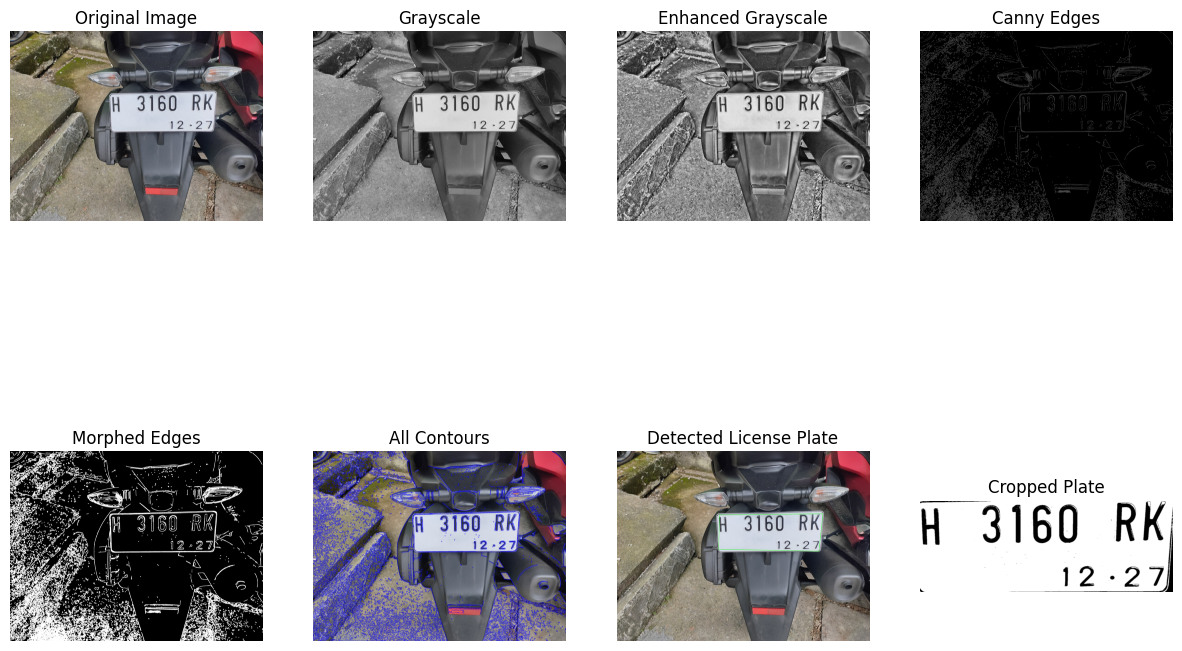

In [ ]:
# NEWEST__________________________________________________________________________________

import cv2
import numpy as np
from matplotlib import pyplot as plt
from pytesseract import image_to_string
import kagglehub
import os

# Download the dataset
path = kagglehub.dataset_download("caasperart/haarcascadeplatenumber")

# Print the path to dataset files
print("Path to dataset files:", path)

# List all files in the dataset directory
files = os.listdir(path)
print("Files in dataset:", files)

all_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        all_files.append(os.path.join(root, file))

# Fungsi untuk menampilkan gambar
def showImage(images, titles, rows, cols):
    fig = plt.figure(figsize=(15, 10))
    total_images = len(images)

    for i in range(rows * cols):
        fig.add_subplot(rows, cols, i + 1)

        if i < total_images:
            if len(images[i].shape) == 2:
                plt.imshow(images[i], 'gray')
            else:
                plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
            plt.title(titles[i])
        else:
            plt.axis('off')

        plt.axis('off')

    plt.show()

# Fungsi untuk mendeteksi dan memotong plat nomor
def detect_license_plate(image_path):
    # Baca gambar
    image = cv2.imread(image_path)
    if image is None:
        print("Gambar tidak ditemukan!")
        return

    # Ubah ke grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Blur untuk mengurangi noise
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    # Tingkatkan kontras dengan CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(50, 50))
    enhanced_gray = clahe.apply(blurred)

    # Deteksi tepi dengan Canny
    edges = cv2.Canny(enhanced_gray, 100, 200)

    # Operasi morfologi-------------------------------------------------------------

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    morphed_edges = cv2.dilate(edges, kernel, iterations=5)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    morphed_edges = cv2.morphologyEx(morphed_edges, cv2.MORPH_OPEN, kernel)

    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # morphed_edges = cv2.morphologyEx(morphed_edges, cv2.MORPH_CLOSE, kernel)

    # Cari kontur------------------------------------------------------------------------
    contours, _ = cv2.findContours(morphed_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Debug: Visualisasi semua kontur
    image_with_all_contours = image.copy()
    cv2.drawContours(image_with_all_contours, contours, -1, (255, 0, 0), 2)

    # Simpan kandidat plat nomor
    license_plate = None
    largest_area = 0

    for contour in contours:
      area = cv2.contourArea(contour)
      if area > 1000:  # Filter area kecil
          epsilon = 0.02 * cv2.arcLength(contour, True)
          approx = cv2.approxPolyDP(contour, epsilon, True)
          if len(approx) == 4:  # Cari kontur dengan 4 sisi
              x, y, w, h = cv2.boundingRect(approx)
              aspect_ratio = w / h

              # Hitung extent
              rect_area = w * h
              extent = float(area) / rect_area

              # Hitung solidity
              hull = cv2.convexHull(contour)
              hull_area = cv2.contourArea(hull)
              solidity = float(area) / hull_area

              # Periksa apakah rasio dan bentuk mendekati plat nomor
              if (2.0 <= aspect_ratio <= 5.0 and  # Rasio aspek
                  extent >= 0.7 and               # Minimal 70% mengisi kotak pembatas
                  solidity >= 0.9 and            # Minimal 90% solid (tidak berlubang)
                  area > largest_area):
                  license_plate = approx
                  largest_area = area

    # Visualisasi hasil
    images_to_show = [image, gray, enhanced_gray, edges, morphed_edges, image_with_all_contours]
    titles = ["Original Image", "Grayscale", "Enhanced Grayscale", "Canny Edges", "Morphed Edges", "All Contours"]

    if license_plate is not None:
        # Gambar kontur pada gambar asli
        image_with_plate = image.copy()
        cv2.drawContours(image_with_plate, [license_plate], -1, (0, 255, 0), 3)

        # Potong plat nomor
        x, y, w, h = cv2.boundingRect(license_plate)
        plate_image = image[y:y+h, x:x+w]

        # Preprocessing untuk OCR
        plate_gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
        _, plate_thresh = cv2.threshold(plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
        morphed_text = cv2.morphologyEx(plate_thresh, cv2.MORPH_CLOSE, kernel)

        blurred = cv2.GaussianBlur(morphed_text, (7, 7), 0)
        # blurred = cv2.medianBlur(morphed_text, 7)

        # Ekstraksi teks
        text = image_to_string(blurred)
        print("Detected Text:", text.strip())

        # Tambahkan ke daftar gambar
        images_to_show.append(image_with_plate)
        images_to_show.append(plate_thresh)
        titles.extend(["Detected License Plate", "Cropped Plate"])

        # Tampilkan gambar
        showImage(images_to_show, titles, 2, 4)
    else:
      print('Tahap 2')
      # Blur untuk mengurangi noise
      blurred = cv2.GaussianBlur(gray, (9, 9), 0)

      # Tingkatkan kontras dengan CLAHE
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(50, 50))
      enhanced_gray = clahe.apply(blurred)

      # Deteksi tepi dengan Canny
      edges = cv2.Canny(enhanced_gray, 100, 200)

      # Operasi morfologi-------------------------------------------------------------

      kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
      morphed_edges = cv2.dilate(edges, kernel, iterations=5)

      # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
      # morphed_edges = cv2.morphologyEx(morphed_edges, cv2.MORPH_OPEN, kernel)

      kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
      morphed_edges = cv2.morphologyEx(morphed_edges, cv2.MORPH_CLOSE, kernel)

      # Cari kontur------------------------------------------------------------------------
      contours, _ = cv2.findContours(morphed_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

      # Debug: Visualisasi semua kontur
      image_with_all_contours = image.copy()
      cv2.drawContours(image_with_all_contours, contours, -1, (255, 0, 0), 2)

      # Simpan kandidat plat nomor
      license_plate = None
      largest_area = 0

      for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000:  # Filter area kecil
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            if len(approx) == 4:  # Cari kontur dengan 4 sisi
                x, y, w, h = cv2.boundingRect(approx)
                aspect_ratio = w / h

                # Hitung extent
                rect_area = w * h
                extent = float(area) / rect_area

                # Hitung solidity
                hull = cv2.convexHull(contour)
                hull_area = cv2.contourArea(hull)
                solidity = float(area) / hull_area

                # Periksa apakah rasio dan bentuk mendekati plat nomor
                if (2.0 <= aspect_ratio <= 5.0 and  # Rasio aspek
                    extent >= 0.7 and               # Minimal 70% mengisi kotak pembatas
                    solidity >= 0.9 and            # Minimal 90% solid (tidak berlubang)
                    area > largest_area):
                    license_plate = approx
                    largest_area = area

      if license_plate is not None:
          # Gambar kontur pada gambar asli
          image_with_plate = image.copy()
          cv2.drawContours(image_with_plate, [license_plate], -1, (0, 255, 0), 3)

          # Potong plat nomor
          x, y, w, h = cv2.boundingRect(license_plate)
          plate_image = image[y:y+h, x:x+w]

          # Preprocessing untuk OCR
          plate_gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
          _, plate_thresh = cv2.threshold(plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

          kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
          morphed_text = cv2.morphologyEx(plate_thresh, cv2.MORPH_CLOSE, kernel)

          blurred = cv2.GaussianBlur(morphed_text, (7, 7), 0)
          # blurred = cv2.medianBlur(morphed_text, 7)

          # Ekstraksi teks
          text = image_to_string(blurred)
          print("Detected Text:", text.strip())

          # Tambahkan ke daftar gambar
          images_to_show.append(image_with_plate)
          images_to_show.append(plate_thresh)
          titles.extend(["Detected License Plate", "Cropped Plate"])

          # Tampilkan gambar
          showImage(images_to_show, titles, 2, 4)

      else:
          print("Tahap 3")
          # Blur untuk mengurangi noise
          blurred = cv2.GaussianBlur(gray, (7, 7), 0)

          # Tingkatkan kontras dengan CLAHE
          clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(50, 50))
          enhanced_gray = clahe.apply(blurred)

          # 2. Deteksi tepi menggunakan Sobel
          sobel_x = cv2.Sobel(enhanced_gray, cv2.CV_64F, 1, 0, ksize=3)  # Sobel X
          sobel_y = cv2.Sobel(enhanced_gray, cv2.CV_64F, 0, 1, ksize=3)  # Sobel Y
          sobel_combined = cv2.addWeighted(cv2.convertScaleAbs(sobel_x), 0.5,
                                          cv2.convertScaleAbs(sobel_y), 0.5, 0)

          # 3. Dilasi untuk mempertebal tepi
          kernel_dilate = np.ones((3, 3), np.uint8)
          dilated = cv2.dilate(sobel_combined, kernel_dilate, iterations=3)

          # 4. Filling menggunakan threshold
          _, thresh = cv2.threshold(dilated, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
          filled = thresh.copy()
          contours, _ = cv2.findContours(filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          for contour in contours:
              cv2.drawContours(filled, [contour], -1, 255, thickness=-1)

          # 5. Morphological Opening untuk membersihkan noise
          kernel_open = np.ones((7, 7), np.uint8)
          morphed = cv2.morphologyEx(filled, cv2.MORPH_OPEN, kernel_open)

          # 6. Cari kontur dari hasil akhir
          contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

          # Simpan kandidat plat nomor
          license_plate = None
          largest_area = 0

          for contour in contours:
              area = cv2.contourArea(contour)
              if area > 500:  # Filter area kecil
                  epsilon = 0.018 * cv2.arcLength(contour, True)
                  approx = cv2.approxPolyDP(contour, epsilon, True)
                  if len(approx) == 4 and area > largest_area:  # Cari kontur dengan 4 sisi
                      license_plate = approx
                      largest_area = area

          # Visualisasi hasil
          images_to_show = [image, gray, sobel_combined, dilated, filled, morphed]
          titles = ["Original Image", "Grayscale", "Sobel Edges", "Dilated", "Filled", "Morphological Opening"]

          if license_plate is not None:
              # Gambar kontur pada gambar asli
              image_with_plate = image.copy()
              cv2.drawContours(image_with_plate, [license_plate], -1, (0, 255, 0), 3)

              # Potong plat nomor dengan rasio khusus (contoh: 2:1 untuk motor)
              x, y, w, h = cv2.boundingRect(license_plate)

              # Rasio target untuk plat motor
              target_ratio = 5 / 2

              # Sesuaikan bounding rectangle agar sesuai dengan rasio
              if w / h > target_ratio:
                  # Lebar lebih besar dari rasio target, sesuaikan tinggi
                  new_h = int(w / target_ratio)
                  y -= (new_h - h) // 2
                  h = new_h
              else:
                  # Tinggi lebih besar dari rasio target, sesuaikan lebar
                  new_w = int(h * target_ratio)
                  x -= (new_w - w) // 2
                  w = new_w

              # Pastikan bounding rectangle tidak keluar dari gambar
              x = max(0, x)
              y = max(0, y)
              w = min(w, image.shape[1] - x)
              h = min(h, image.shape[0] - y)

              # Potong plat nomor
              plate_image = image[y:y+h, x:x+w]

              # Tambahkan ke daftar gambar untuk ditampilkan
              images_to_show.append(image_with_plate)
              images_to_show.append(plate_image)
              titles.extend(["Detected License Plate", "Cropped Plate"])

              # Tampilkan semua gambar dengan fungsi custom
              showImage(images_to_show, titles, 2, 4)

              text = image_to_string(plate_image)
              print("Detected Text:", text)

          else:
              print("Plat nomor tidak ditemukan!")
              showImage(images_to_show, titles, 2, 4)



# Specify the file you want to display
specific_file = "H3160RK.jpg"

file_to_display = None
for file in all_files:
    if os.path.basename(file) == specific_file:
        file_to_display = file
        break

# Path ke gambar input
image_path = file_to_display  # Ganti dengan path gambar Anda
detect_license_plate(image_path)
